This notebook is an example of how to isolate self-installed add-ons. Due to Firefox initiatives like Test Pilot and Shield, the add-ons population sometimes gets polluted with "special" add-ons that (in the data) look like normal, self-installed add-ons. 


Whats the deal?

 1. Test Pilot add-ons technically are self installed, however these add-ons are a Firefox initiative and aren't always "self discovered". Those that do install TP add-ons, are typically advanced users part of an "opt-in" group.

 2. Shield add-ons are used in either opt-in or opt-out experiments. We especially want to ignore opt-out shield add-ons, as they are silently installed without the user's knowledge (clearly not a self-install). We ignore opt-in shield studies for reasons outline in (1).
 
 3. The goal is to isolate the average add-on user

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import urllib
import json
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as st

sns.set_style('whitegrid')
% matplotlib inline

/mnt/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The functions and objects in the cell below allow us to filter out the add-ons we don't consider self-installs. 

We will filter addons that

* Are a system add-on ( `is_system=True` )
* Are a side-loaded add-on ( `foreign_install=True`)
* Are **not** a Test Pilot Add-on
* Are **not** the Unified Search Experiment
* Do **not** contain `@mozilla` or `@shield.mozilla` in their id

In the future, all shield add-ons will be suffixed by `@shield.mozilla*`, however there are some still in the wild, (or were at some point in the wild) that use a `@mozilla*` suffix or have no mozilla reference in their guid (i.e. the Unified Search Experiment, which was a huge experiment and responsible for the now deprecated charts that live at the bottom of [this dashboard](https://sql.telemetry.mozilla.org/dashboard/add-on-okrs_1)).


All this logic is applied in the `has_self_installs()` UDF.


In [8]:
def get_test_pilot_addons():
    '''
    Fetches all the live test pilot experiments listed in
    the experiments.json file. 
    
    returns a list of addon_ids
    '''
    url = "https://testpilot.firefox.com/api/experiments.json"
    response = urllib.urlopen(url)
    data = json.loads(response.read())
    all_tp_addons = ["@testpilot-addon"] + [i.get("addon_id") for i in data['results'] if i.get("addon_id")]
    return all_tp_addons



# grab all tp addons without a mozilla suffix
NON_MOZ_TP = [i for i in get_test_pilot_addons() if "@mozilla" not in i]

# this study is everywhere
UNIFIED_SEARCH_STR = '@unified-urlbar-shield-study-'

def _has_self_installs(addons):
    if addons:
        for i in addons:
            addon_id = i.addon_id
            if not i.is_system and not i.foreign_install:
                if addon_id not in NON_MOZ_TP and UNIFIED_SEARCH_STR not in addon_id:
                    return "@mozilla" not in addon_id and "@shield.mozilla" not in addon_id
    return False

has_self_installs = F.udf(_has_self_installs, st.BooleanType())

 Load 1% of `main_summary` for release over last week


In [5]:
one_week_ago = (dt.datetime.now() - dt.timedelta(days=7)).strftime("%Y%m%d")

In [6]:
# load 1% of main_summary for release over last week
ms = sqlContext.read.option("mergeSchema", True)\
               .parquet("s3://telemetry-parquet/main_summary/v4")\
               .filter("normalized_channel = 'release'")\
               .filter("app_name = 'Firefox'")\
               .filter("sample_id = '42'")\
               .filter("submission_date_s3 >= '{}'".format(one_week_ago))

In [9]:
df = ms.select("submission_date_s3", 
               "client_id", 
               has_self_installs("active_addons").alias("has_self_installs"))\
       .distinct()\
       .groupBy("submission_date_s3", "has_self_installs").count().toPandas()

Just some gross pandas munging

In [10]:
# format date
df.submission_date_s3 = pd.to_datetime(df.submission_date_s3, format='%Y%m%d')

In [11]:
# get total daily count of clients
agg = df[['submission_date_s3', 'count']].groupby('submission_date_s3').sum().reset_index()
agg.columns = ['submission_date_s3', 'count_total']

In [12]:
# merge and create percentage
df_merged = pd.merge(df, agg, on='submission_date_s3')
df_merged['pct_self_installs'] = df_merged['count']  / df_merged['count_total'] * 100

Note that we see day-of-week effects for the percentage of users with self-installed add-ons. The percentage goes up on the weekends. Overall, when smoothed, the percentage of users with self-installs is ~40%. You can also see this line over a longer history [here](https://metrics.mozilla.com/protected/bmiroglio/firefox-addons/_site/addonCounts-release-beta.html).

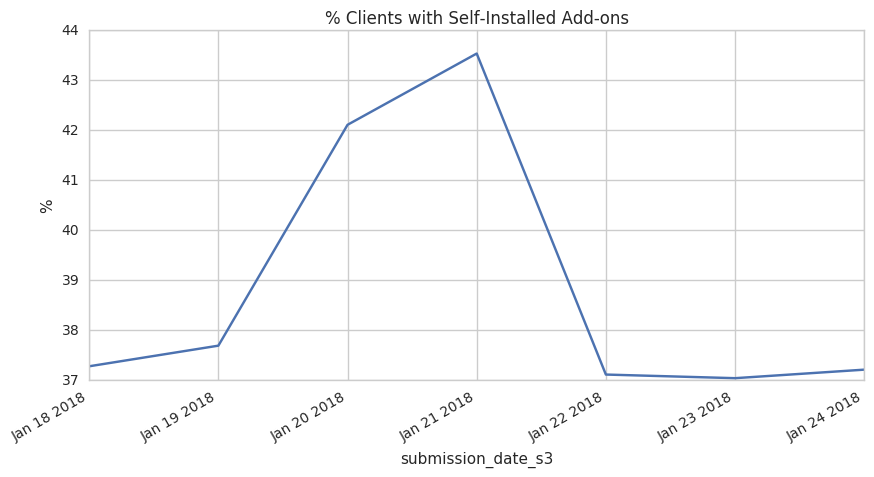

In [24]:
plt.rcParams['figure.figsize'] = (10, 5)

df_merged[df_merged.has_self_installs==True]\
  .plot(x='submission_date_s3', 
        y='pct_self_installs', 
        title="% Clients with Self-Installed Add-ons",
        legend=False)
plt.ylabel('%')
plt.show()